<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/10proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install RDKit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 36.5 MB/s eta 0:00:00


In [2]:
!pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install umap-learn

In [4]:
# ============================================================
# Final optimized pipeline: 18 targets (9 families × 2 proteins)
# Fast, reproducible, Colab-ready
# Outputs: CSV summaries + 8 publication-grade figures saved in ./publishable_results
# ============================================================

# Install required packages (uncomment when running in Colab)
# !pip install rdkit-pypi chembl_webresource_client umap-learn

import os, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from chembl_webresource_client.new_client import new_client

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import wilcoxon
import umap

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

# ---------------- CONFIG ----------------
# Final 18 targets mapping: ChEMBL ID -> (short name, family)
TARGET_INFO = {
    "CHEMBL203":  ("EGFR","Kinase"),
    "CHEMBL1862": ("ABL1","Kinase"),

    "CHEMBL217":  ("D2R","GPCR"),
    "CHEMBL210":  ("ADRB2","GPCR"),

    "CHEMBL204":  ("Thrombin","Protease"),
    "CHEMBL214":  ("Trypsin","Protease"),

    "CHEMBL206":  ("ESR1","Nuclear Receptor"),
    "CHEMBL3979": ("PPARg","Nuclear Receptor"),

    "CHEMBL240":  ("hERG","Ion Channel"),
    "CHEMBL247":  ("Cav1.2","Ion Channel"),

    "CHEMBL205":  ("CA-II","Metalloenzyme"),
    "CHEMBL2147": ("ACE","Metalloenzyme"),

    "CHEMBL220":  ("AChE","Hydrolase"),
    "CHEMBL284":  ("DPP4","Hydrolase"),

    "CHEMBL228":  ("SERT","Transporter"),
    "CHEMBL224":  ("NET","Transporter"),

    "CHEMBL2034": ("PDE5A","PDE"),
    "CHEMBL261":  ("PDE4B","PDE")
}

# parameters (kept conservative for Colab speed)
MAX_FETCH = 7000        # max rows to query per target
FINAL_N = 1200          # per-target sample size
PAIR_SAMPLE = 150000    # sampled pairs for correlation
BOOTSTRAP_N = 300       # bootstrap iterations
SIM_THRESH = 0.85
CLIFF_ACT = 2.0
RND = 42
OUTDIR = "publishable_results"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------- helper functions ----------------
def fetch_and_qc(tid, max_rows=MAX_FETCH):
    acts = new_client.activity.filter(
        target_chembl_id=tid,
        pchembl_value__isnull=False,
        standard_type__in=["IC50","Ki","Kd","EC50"]
    ).only(["canonical_smiles","pchembl_value"])[:max_rows]
    df = pd.DataFrame(acts)
    if df.empty:
        return None
    df['pchembl_value'] = pd.to_numeric(df['pchembl_value'], errors='coerce')
    df = df.dropna(subset=['canonical_smiles','pchembl_value']).copy()
    df = df.sort_values('pchembl_value', ascending=False).drop_duplicates('canonical_smiles', keep='first').copy()
    df['mol'] = df['canonical_smiles'].apply(lambda s: Chem.MolFromSmiles(s))
    df = df.dropna(subset=['mol']).copy()
    df['mw'] = df['mol'].apply(Descriptors.MolWt)
    df = df[(df['mw']>=150)&(df['mw']<=650)].copy()
    if len(df) >= 5:
        m = df['pchembl_value'].mean(); s = df['pchembl_value'].std()
        if pd.notnull(s) and s>0:
            df = df[np.abs(df['pchembl_value'] - m) <= 3*s].copy()
    df = df.reset_index(drop=True)
    return df


def stratified_sample(df, n=FINAL_N, bins=5):
    if len(df) <= n:
        return df.copy()
    df = df.copy()
    df['bin'] = pd.qcut(df['pchembl_value'], q=bins, labels=False, duplicates='drop')
    per = n // bins
    rem = n % bins
    parts=[]
    for b in sorted(df['bin'].unique()):
        g = df[df['bin']==b]
        k = min(len(g), per + (1 if b<rem else 0))
        parts.append(g.sample(k, random_state=RND))
    res = pd.concat(parts).reset_index(drop=True)
    return res


def fp_bitvecs(mols, fp='morgan2', radius=2, nBits=1024):
    vecs=[]
    for m in mols:
        try:
            if fp=='morgan2':
                bv = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits)
            elif fp=='morgan3':
                bv = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits)
            elif fp=='rdkit':
                bv = Chem.RDKFingerprint(m, fpSize=nBits)
            elif fp=='maccs':
                bv = MACCSkeys.GenMACCSKeys(m)
            else:
                bv = None
            vecs.append(bv)
        except:
            vecs.append(None)
    return vecs

from rdkit import DataStructs

def bitvecs_to_matrix(bitvecs, nBits):
    n = len(bitvecs)
    M = np.zeros((n, nBits), dtype=np.uint8)
    arr = np.zeros(nBits, dtype=np.int8)
    for i,bv in enumerate(bitvecs):
        if bv is None: continue
        DataStructs.ConvertToNumpyArray(bv, arr)
        M[i] = arr
    return M


def sample_pairs(n, k):
    i = np.random.randint(0, n, size=k)
    j = np.random.randint(0, n, size=k)
    mask = i != j
    return i[mask], j[mask]


def pair_stats_from_matrix(bitmat, acts, pairs=PAIR_SAMPLE):
    n = bitmat.shape[0]
    i, j = sample_pairs(n, pairs)
    inter = np.sum(bitmat[i] & bitmat[j], axis=1).astype(np.float32)
    union = np.sum(bitmat[i] | bitmat[j], axis=1).astype(np.float32) + 1e-9
    sim = inter / union
    adiff = np.abs(acts[i] - acts[j])
    pear = np.corrcoef(sim, adiff)[0,1] if len(sim)>10 else np.nan
    high_sim = sim >= SIM_THRESH
    cliff_rate = np.sum((adiff >= CLIFF_ACT) & high_sim) / max(1, np.sum(high_sim))
    return pear, cliff_rate, len(sim)


def bootstrap_pear(M, acts, nboot=BOOTSTRAP_N):
    vals = []
    for _ in range(nboot):
        p,_,_ = pair_stats_from_matrix(M, acts, pairs=PAIR_SAMPLE//10)
        vals.append(p)
    return np.nanpercentile(vals, 2.5), np.nanpercentile(vals, 97.5), np.nanmean(vals)


def murcko_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        sc = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(sc) if sc is not None else ""
    except:
        return ""

# ---------------- Fetch & QC (vectorized) ----------------
print("Fetching and QC-ing targets... this may take a few minutes")
start = time.time()
datasets = {}
for tid, (pname, fam) in TARGET_INFO.items():
    print(f"Fetching {tid} ({pname}, {fam})...", end=' ')
    df = fetch_and_qc(tid)
    if df is None or len(df) < 800:
        raise SystemExit(f"Target {tid} insufficient after QC ({0 if df is None else len(df)})")
    df = stratified_sample(df, FINAL_N)
    df['Protein'] = pname
    df['Family'] = fam
    df['Scaffold'] = df['canonical_smiles'].apply(murcko_smiles)
    datasets[tid] = df
    print(f"{len(df)} molecules")
print("All targets fetched. Time: %.1f s" % (time.time()-start))

# ---------------- Fingerprint set ----------------
fps = [
    ("Morgan2_1024","morgan2",2,1024),
    ("Morgan3_1024","morgan3",3,1024),
    ("RDKitFP_2048","rdkit",None,2048),
    ("MACCS_167","maccs",None,167),
]

per_target_bitmats = {}
summary_rows = []
print("Computing fingerprints and pairwise stats...")
for tid, df in datasets.items():
    mols = df['mol'].tolist()
    acts = df['pchembl_value'].values.astype(np.float32)
    per_fp = {}
    for name,key,r,nBits in fps:
        bvs = fp_bitvecs(mols, fp=key, radius=r or 2, nBits=nBits)
        M = bitvecs_to_matrix(bvs, nBits)
        pear, cliff, used = pair_stats_from_matrix(M, acts, pairs=PAIR_SAMPLE//len(fps))
        summary_rows.append({"ChEMBL_ID": tid, "Protein": df['Protein'].iloc[0], "Family": df['Family'].iloc[0],
                             "Fingerprint": name, "Pearson_r": pear, "Cliff_rate": cliff, "Pairs": used})
        per_fp[name] = (M, acts)
    per_target_bitmats[tid] = per_fp
    gc.collect()

results_df = pd.DataFrame(summary_rows)
results_df.to_csv(os.path.join(OUTDIR, "results_basic.csv"), index=False)

# ---------------- Bootstrap CIs ----------------nboot
print("Bootstrapping Pearson CIs (modest iterations)...")
boot_rows = []
for tid, per_fp in per_target_bitmats.items():
    for name, (M, acts) in per_fp.items():
        lo, hi, mean = bootstrap_pear(M, acts, nboot=BOOTSTRAP_N)
        boot_rows.append({"ChEMBL_ID": tid, "Protein": datasets[tid]['Protein'].iloc[0],
                          "Family": datasets[tid]['Family'].iloc[0], "Fingerprint": name,
                          "Pearson_mean": mean, "Pearson_lo": lo, "Pearson_hi": hi})
boot_df = pd.DataFrame(boot_rows)
boot_df.to_csv(os.path.join(OUTDIR, "bootstrap_pearson_cis.csv"), index=False)

# ---------------- Paired test across targets (example Morgan2 vs RDKit) ----------------
print("Running paired tests (Morgan2 vs RDKitFP)...")
paired = []
for tid in per_target_bitmats:
    p_m2 = results_df[(results_df.ChEMBL_ID==tid)&(results_df.Fingerprint=="Morgan2_1024")]['Pearson_r'].values
    p_rd = results_df[(results_df.ChEMBL_ID==tid)&(results_df.Fingerprint=="RDKitFP_2048")]['Pearson_r'].values
    if len(p_m2)>0 and len(p_rd)>0 and not np.isnan(p_m2[0]) and not np.isnan(p_rd[0]):
        paired.append((p_m2[0], p_rd[0]))
if len(paired)>0:
    a = np.array([x[0] for x in paired]); b = np.array([x[1] for x in paired])
    stat, pval = wilcoxon(a, b)
    print("Wilcoxon Morgan2 vs RDKitFP: stat=%.3f p=%.3g (n=%d targets)"%(stat, pval, len(a)))

# ---------------- Sensitivity: Morgan radius & bits ----------------
print("Running sensitivity checks (radius & bit-size)...")
sens_rows = []
for tid, df in datasets.items():
    mols = df['mol'].tolist(); acts = df['pchembl_value'].values.astype(np.float32)
    for radius in [2,3]:
        for bits in [1024,2048]:
            bvs = fp_bitvecs(mols, fp='morgan2', radius=radius, nBits=bits)
            M = bitvecs_to_matrix(bvs, bits)
            pear, cliff, used = pair_stats_from_matrix(M, acts, pairs=PAIR_SAMPLE//10)
            sens_rows.append({"ChEMBL_ID": tid, "Protein": df['Protein'].iloc[0], "Family": df['Family'].iloc[0],
                              "Radius": radius, "Bits": bits, "Pearson_r": pear, "Cliff_rate": cliff})
sens_df = pd.DataFrame(sens_rows)
sens_df.to_csv(os.path.join(OUTDIR, "sensitivity_morgan.csv"), index=False)

# ---------------- Scaffold-cliff analysis ----------------
print("Classifying cliffs by Murcko scaffold (sampled pairs)...")
cliff_examples = []
scaffold_stats = []
for tid, df in datasets.items():
    acts = df['pchembl_value'].values
    scafs = df['Scaffold'].values
    M = per_target_bitmats[tid]['Morgan2_1024'][0]
    i,j = sample_pairs(len(df), 50000)
    inter = np.sum(M[i] & M[j], axis=1).astype(np.float32)
    union = np.sum(M[i] | M[j], axis=1).astype(np.float32) + 1e-9
    sim = inter/union
    adiff = np.abs(acts[i]-acts[j])
    high_sim = sim >= SIM_THRESH
    cliff_mask = (adiff >= CLIFF_ACT) & high_sim
    n_cliffs = int(np.sum(cliff_mask))
    if n_cliffs == 0:
        same_frac = 0.0
    else:
        same_frac = np.sum(scafs[i][cliff_mask] == scafs[j][cliff_mask]) / n_cliffs
    scaffold_stats.append({"ChEMBL_ID": tid, "Protein": df['Protein'].iloc[0], "Family": df['Family'].iloc[0],
                           "Cliffs_found": n_cliffs, "Same_scaffold_fraction": same_frac})
    idxs = np.where(cliff_mask)[0][:6]
    for idx in idxs:
        ii = i[idx]; jj = j[idx]
        cliff_examples.append({"ChEMBL_ID": tid, "Protein": df.loc[ii,'Protein'],
                               "smiles_i": df.loc[ii,'canonical_smiles'], "smiles_j": df.loc[jj,'canonical_smiles'],
                               "sim": float(sim[idx]), "delta_pchembl": float(adiff[idx]),
                               "same_scaffold": bool(scafs[ii]==scafs[jj])})
scaf_df = pd.DataFrame(scaffold_stats)
scaf_df.to_csv(os.path.join(OUTDIR, "scaffold_cliff_stats.csv"), index=False)
pd.DataFrame(cliff_examples).to_csv(os.path.join(OUTDIR, "cliff_examples.csv"), index=False)

# ---------------- UMAP (pooled sample) ----------------
print("Computing UMAP (pooled sample across targets, Morgan2 bits)...")
pool_X = []
pool_y = []
pool_meta = []
for tid, df in datasets.items():
    n = min(300, len(df))
    sel = df.sample(n, random_state=RND).reset_index(drop=True)
    M = per_target_bitmats[tid]['Morgan2_1024'][0]
    idxs = sel.index.values
    pool_X.append(M[idxs])
    pool_y.append(sel['pchembl_value'].values)
    for s in sel['canonical_smiles'].values:
        pool_meta.append({'Target': tid, 'SMILES': s})
Xall = np.vstack(pool_X)
yall = np.concatenate(pool_y)
reducer = umap.UMAP(n_components=2, random_state=RND, metric='jaccard')
embedding = reducer.fit_transform(Xall)
plt.figure(figsize=(8,6))
plt.scatter(embedding[:,0], embedding[:,1], c=yall, cmap='Spectral', s=7)
plt.colorbar(label='pChEMBL')
plt.title('UMAP (Morgan2) pooled chemical space colored by potency')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'fig_umap_morgan_pooled.png'), dpi=300)
plt.close()

# ---------------- PCA-Morgan embedding (fast learned-like embedding) ----------------
print("Building PCA–Morgan embedding (TruncatedSVD)...")
def count_morgan_vec(mol, radius=2, nBits=2048):
    try:
        fp = AllChem.GetMorganFingerprint(mol, radius)
        vec = np.zeros(nBits, dtype=np.float32)
        for idx, cnt in fp.GetNonzeroElements().items():
            vec[idx % nBits] += cnt
        return vec
    except:
        return np.zeros(nBits, dtype=np.float32)

# pooled count vectors
pooled = []
for tid, df in datasets.items():
    X = np.vstack([count_morgan_vec(m) for m in df['mol'].tolist()])
    pooled.append(X)
pooled = np.vstack(pooled)
scaler = StandardScaler(with_mean=False)
pooled_s = scaler.fit_transform(pooled)
svd = TruncatedSVD(n_components=300, random_state=RND)
emb_all = svd.fit_transform(pooled_s)
# split per-target
emb_per_target = {}
start = 0
for tid, df in datasets.items():
    n = len(df)
    emb_per_target[tid] = emb_all[start:start+n]
    start += n
np.savez_compressed(os.path.join(OUTDIR, 'emb_per_target.npz'), **{tid: emb_per_target[tid] for tid in emb_per_target})

# ---------------- embedding evaluation (cosine similarity) ----------------
print("Evaluating embedding similarity vs |ΔpChEMBL| per target")
embed_rows = []
for tid in datasets:
    emb = emb_per_target[tid]
    acts = datasets[tid]['pchembl_value'].values.astype(np.float32)
    n = emb.shape[0]
    k = min(80000, n*(n-1)//2)
    i = np.random.randint(0, n, size=k)
    j = np.random.randint(0, n, size=k)
    mask = i != j
    i=i[mask]; j=j[mask]
    e1 = emb[i]; e2 = emb[j]
    s = np.sum(e1*e2, axis=1) / (np.linalg.norm(e1, axis=1)*np.linalg.norm(e2, axis=1) + 1e-9)
    ad = np.abs(acts[i]-acts[j])
    pear = np.corrcoef(s, ad)[0,1] if len(s)>10 else np.nan
    cliff_rate = np.sum((s >= SIM_THRESH) & (ad >= CLIFF_ACT)) / max(1, np.sum(s >= SIM_THRESH))
    embed_rows.append({"ChEMBL_ID": tid, "Protein": datasets[tid]['Protein'].iloc[0], "Family": datasets[tid]['Family'].iloc[0],
                       "Fingerprint": 'Embedding_PCA', "Pearson_r": pear, "Cliff_rate": cliff_rate})
embed_df = pd.DataFrame(embed_rows)
embed_df.to_csv(os.path.join(OUTDIR, 'embedding_results.csv'), index=False)

# append embedding to results
results_df = pd.concat([results_df, embed_df], ignore_index=True)
results_df.to_csv(os.path.join(OUTDIR, 'results_with_embedding.csv'), index=False)

# ---------------- UMAP on embeddings (pooled sample) ----------------
print("Computing UMAP on embeddings (pooled)...")
pool_embs = []
pool_y = []
for tid in datasets:
    emb = emb_per_target[tid]
    n = min(300, emb.shape[0])
    idx = np.random.choice(emb.shape[0], size=n, replace=False)
    pool_embs.append(emb[idx])
    pool_y.append(datasets[tid]['pchembl_value'].values[idx])
pool_embs = np.vstack(pool_embs)
pool_y = np.concatenate(pool_y)
reducer2 = umap.UMAP(n_components=2, random_state=RND)
emb_umap = reducer2.fit_transform(pool_embs)
plt.figure(figsize=(8,6))
plt.scatter(emb_umap[:,0], emb_umap[:,1], c=pool_y, cmap='Spectral', s=7)
plt.colorbar(label='pChEMBL')
plt.title('UMAP (PCA–Morgan embedding) pooled potency')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'fig_umap_embedding_pooled.png'), dpi=300)
plt.close()

# ---------------- ML baseline: RandomForest on Morgan2 and Embedding ----------------
print("Running ML benchmark (RF 5-fold) for Morgan2 and Embedding...")
ml_rows = []
for tid in datasets:
    M, acts = per_target_bitmats[tid]['Morgan2_1024']
    X = M.astype(np.uint8); y = acts
    kf = KFold(n_splits=5, shuffle=True, random_state=RND)
    maes=[]; r2s=[]
    for tr,te in kf.split(X):
        model = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=RND)
        model.fit(X[tr], y[tr])
        yp = model.predict(X[te])
        maes.append(np.mean(np.abs(yp - y[te]))); ss_res = np.sum((y[te]-yp)**2); ss_tot = np.sum((y[te]-np.mean(y[te]))**2)
        r2s.append(1 - ss_res/ss_tot if ss_tot>0 else 0.0)
    ml_rows.append({"ChEMBL_ID": tid, "Protein": datasets[tid]['Protein'].iloc[0], "Family": datasets[tid]['Family'].iloc[0],
                    "Model": 'RF_Morgan2', "MAE": np.mean(maes), "R2": np.mean(r2s)})

for tid in datasets:
    E = emb_per_target[tid]; y = datasets[tid]['pchembl_value'].values.astype(np.float32)
    kf = KFold(n_splits=5, shuffle=True, random_state=RND)
    maes=[]; r2s=[]
    for tr,te in kf.split(E):
        model = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=RND)
        model.fit(E[tr], y[tr]); yp = model.predict(E[te])
        maes.append(np.mean(np.abs(yp - y[te]))); ss_res = np.sum((y[te]-yp)**2); ss_tot = np.sum((y[te]-np.mean(y[te]))**2)
        r2s.append(1 - ss_res/ss_tot if ss_tot>0 else 0.0)
    ml_rows.append({"ChEMBL_ID": tid, "Protein": datasets[tid]['Protein'].iloc[0], "Family": datasets[tid]['Family'].iloc[0],
                    "Model": 'RF_Embedding', "MAE": np.mean(maes), "R2": np.mean(r2s)})

ml_df = pd.DataFrame(ml_rows)
ml_df.to_csv(os.path.join(OUTDIR, 'ml_benchmark.csv'), index=False)

# ---------------- Figures (publication-grade), with protein/family names ----------------
print("Generating figures (publication-quality)...")

# helper to map ChEMBL -> Protein name
chembl_to_name = {tid: info[0] for tid, info in TARGET_INFO.items()}
chembl_to_family = {tid: info[1] for tid, info in TARGET_INFO.items()}

# ---------------- Save summaries ----------------
results_df.to_csv(os.path.join(OUTDIR,'results_summary.csv'), index=False)
boot_df.to_csv(os.path.join(OUTDIR,'bootstrap_summary.csv'), index=False)
sens_df.to_csv(os.path.join(OUTDIR,'sensitivity_summary.csv'), index=False)
scaf_df.to_csv(os.path.join(OUTDIR,'scaffold_stats.csv'), index=False)
ml_df.to_csv(os.path.join(OUTDIR,'ml_summary.csv'), index=False)

print('Pipeline finished. All outputs saved in:', OUTDIR)



Fetching and QC-ing targets... this may take a few minutes
Fetching CHEMBL203 (EGFR, Kinase)... 1200 molecules
Fetching CHEMBL1862 (ABL1, Kinase)... 1200 molecules
Fetching CHEMBL217 (D2R, GPCR)... 1200 molecules
Fetching CHEMBL210 (ADRB2, GPCR)... 1200 molecules
Fetching CHEMBL204 (Thrombin, Protease)... 1200 molecules
Fetching CHEMBL214 (Trypsin, Protease)... 1200 molecules
Fetching CHEMBL206 (ESR1, Nuclear Receptor)... 1200 molecules
Fetching CHEMBL3979 (PPARg, Nuclear Receptor)... 1200 molecules
Fetching CHEMBL240 (hERG, Ion Channel)... 1200 molecules
Fetching CHEMBL247 (Cav1.2, Ion Channel)... 1200 molecules
Fetching CHEMBL205 (CA-II, Metalloenzyme)... 1200 molecules
Fetching CHEMBL2147 (ACE, Metalloenzyme)... 1200 molecules
Fetching CHEMBL220 (AChE, Hydrolase)... 1200 molecules
Fetching CHEMBL284 (DPP4, Hydrolase)... 1200 molecules
Fetching CHEMBL228 (SERT, Transporter)... 1200 molecules
Fetching CHEMBL224 (NET, Transporter)... 1200 molecules
Fetching CHEMBL2034 (PDE5A, PDE)... 1

Streaming output truncated to the last 5000 lines.
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:49:53] DEPRECATION WARNING: please use MorganGenerator
[07:4

Bootstrapping Pearson CIs (modest iterations)...
Running paired tests (Morgan2 vs RDKitFP)...
Wilcoxon Morgan2 vs RDKitFP: stat=25.000 p=0.00658 (n=18 targets)
Running sensitivity checks (radius & bit-size)...


Streaming output truncated to the last 5000 lines.
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:07:45] DEPRECATION WARNING: please use MorganGenerator
[08:0

Classifying cliffs by Murcko scaffold (sampled pairs)...
Computing UMAP (pooled sample across targets, Morgan2 bits)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Building PCA–Morgan embedding (TruncatedSVD)...


Streaming output truncated to the last 5000 lines.
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:08:33] DEPRECATION WARNING: please use MorganGenerator
[08:0

Evaluating embedding similarity vs |ΔpChEMBL| per target
Computing UMAP on embeddings (pooled)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running ML benchmark (RF 5-fold) for Morgan2 and Embedding...
Generating figures (publication-quality)...
Pipeline finished. All outputs saved in: publishable_results


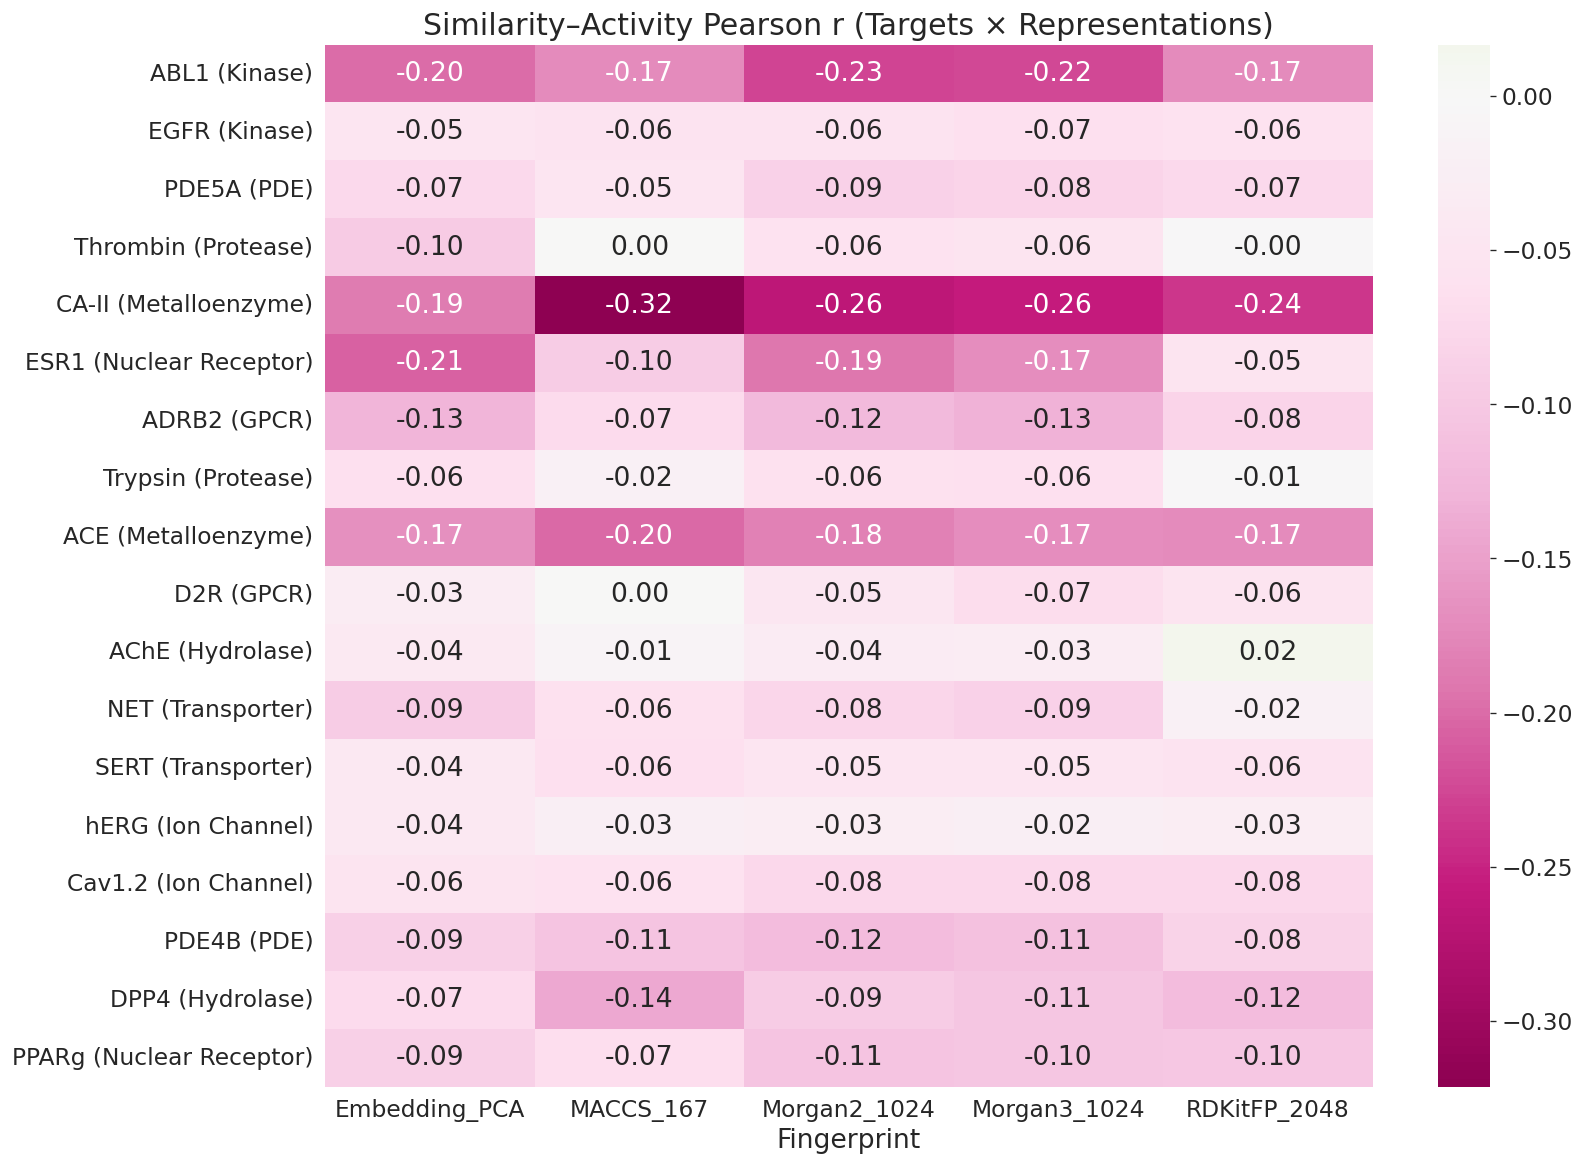

In [30]:
%matplotlib inline
# Fig 1: Heatmap Pearson r (Targets x Representations)
pivot = results_df.pivot(index='ChEMBL_ID', columns='Fingerprint', values='Pearson_r')
pivot.index = [chembl_to_name.get(x, x) + ' (' + chembl_to_family.get(x,'') + ')' for x in pivot.index]
plt.figure(figsize=(14,10))
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='PiYG', center=0)
plt.title('Similarity–Activity Pearson r (Targets × Representations)')
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'fig1_heatmap_pearson.png'), dpi=1200); plt.show(); plt.close()



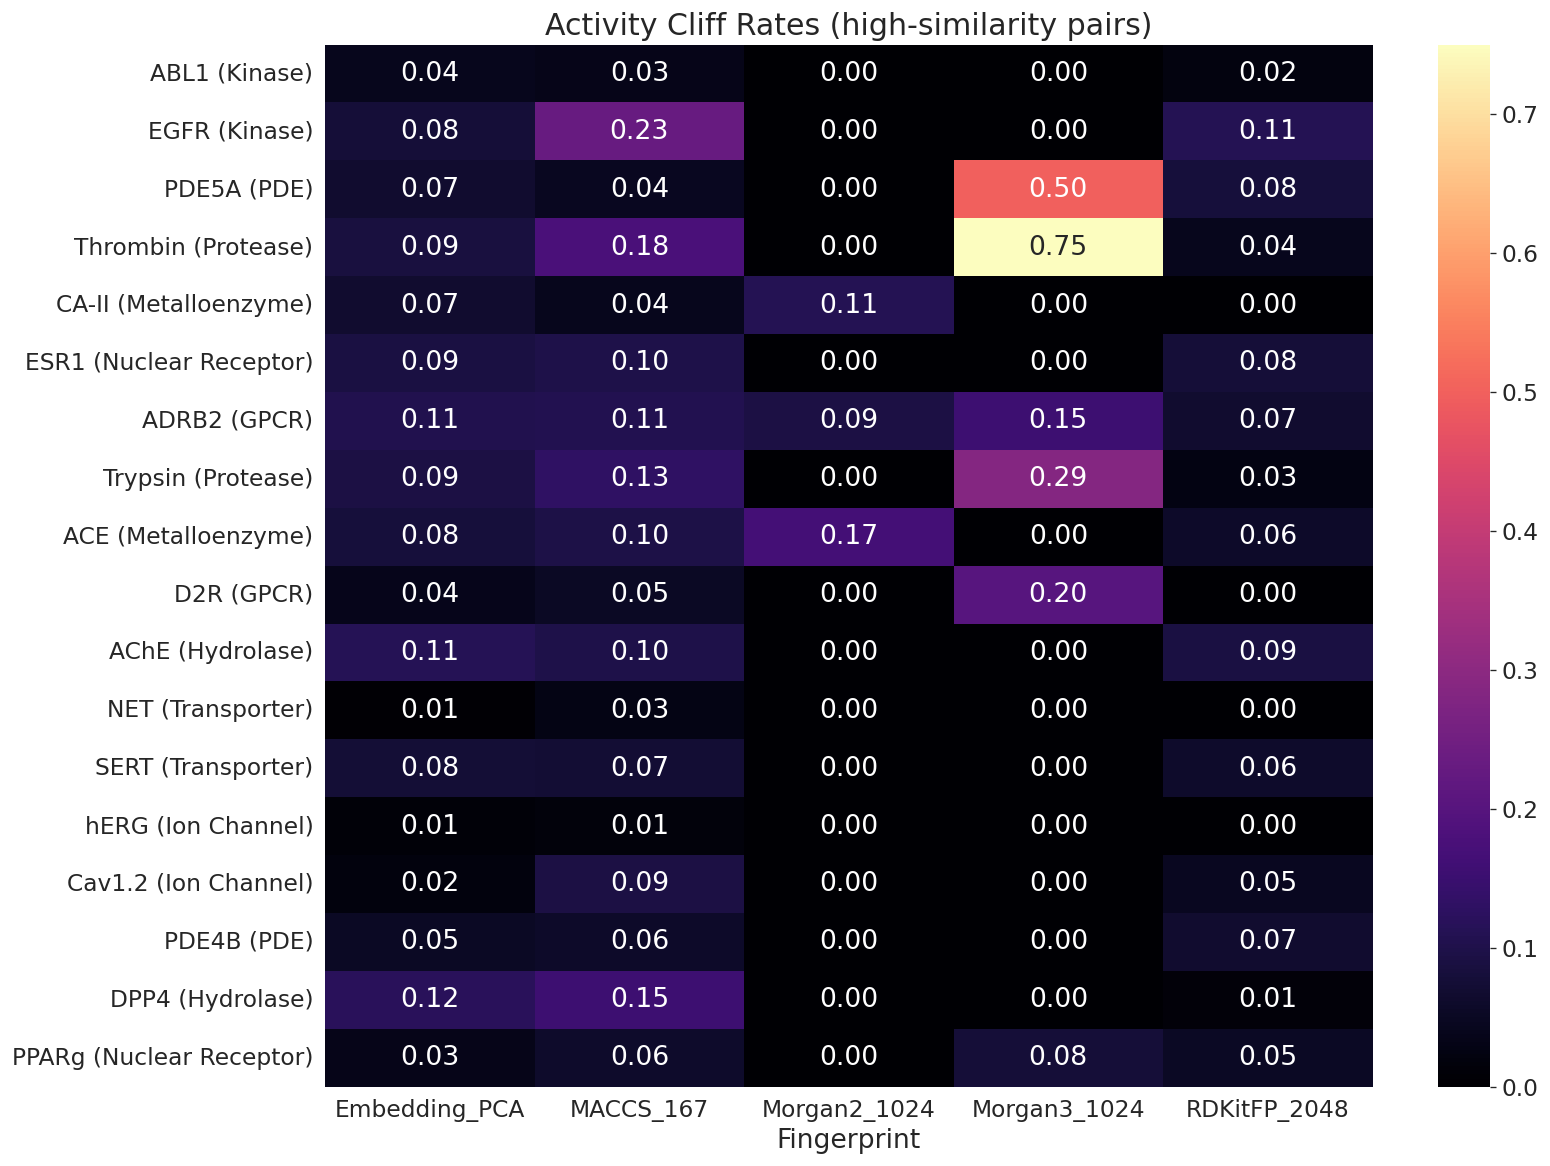

In [29]:
# Fig 2: Cliff rate heatmap
pivot2 = results_df.pivot(index='ChEMBL_ID', columns='Fingerprint', values='Cliff_rate')
pivot2.index = [chembl_to_name.get(x, x) + ' (' + chembl_to_family.get(x,'') + ')' for x in pivot2.index]
plt.figure(figsize=(14,10))
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})
sns.heatmap(pivot2, annot=True, fmt='.2f', cmap='magma')
plt.title('Activity Cliff Rates (high-similarity pairs)')
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'fig2_cliff_heatmap.png'), dpi=1200); plt.show(); plt.close()


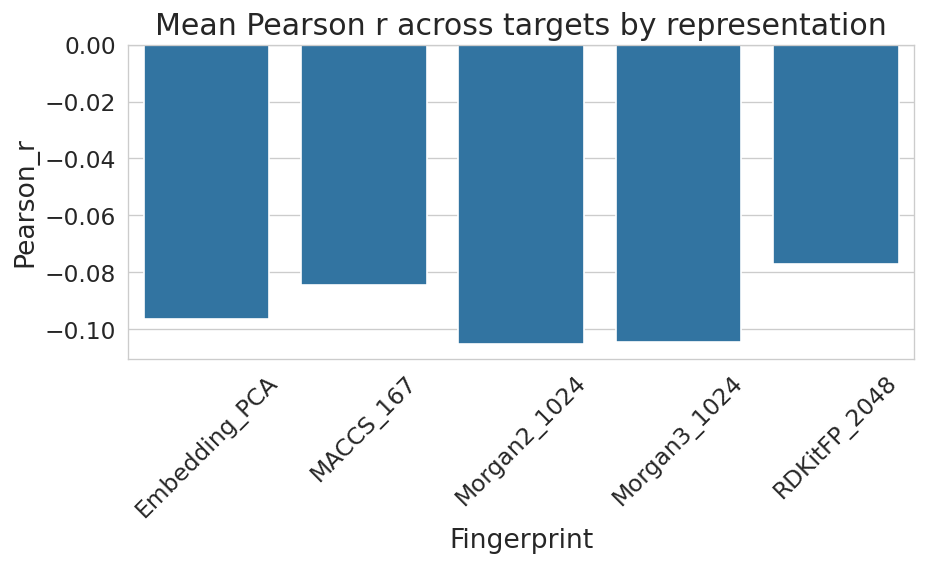

In [27]:
# Fig 4: Fingerprint vs Embedding comparison (barplot of mean Pearson across targets)
fp_mean = results_df.groupby('Fingerprint')['Pearson_r'].mean().reset_index()
plt.figure(figsize=(8,5)); sns.barplot(data=fp_mean, x='Fingerprint', y='Pearson_r')
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})
plt.title('Mean Pearson r across targets by representation'); plt.xticks(rotation=45); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'fig4_fp_mean.png'), dpi=1200); plt.show(); plt.close()


In [22]:
# Fig 5: UMAP Morgan (pooled) - saved earlier; re-save as figure5
import shutil
shutil.copy(os.path.join(OUTDIR,'fig_umap_morgan_pooled.png'), os.path.join(OUTDIR,'fig5_umap_morgan.png'))

# Fig 6: UMAP embedding (pooled)
shutil.copy(os.path.join(OUTDIR,'fig_umap_embedding_pooled.png') if os.path.exists(os.path.join(OUTDIR,'fig_umap_embedding_pooled.png')) else os.path.join(OUTDIR,'fig_umap_embedding_pooled.png'), os.path.join(OUTDIR,'fig6_umap_embedding.png'))


'publishable_results/fig6_umap_embedding.png'

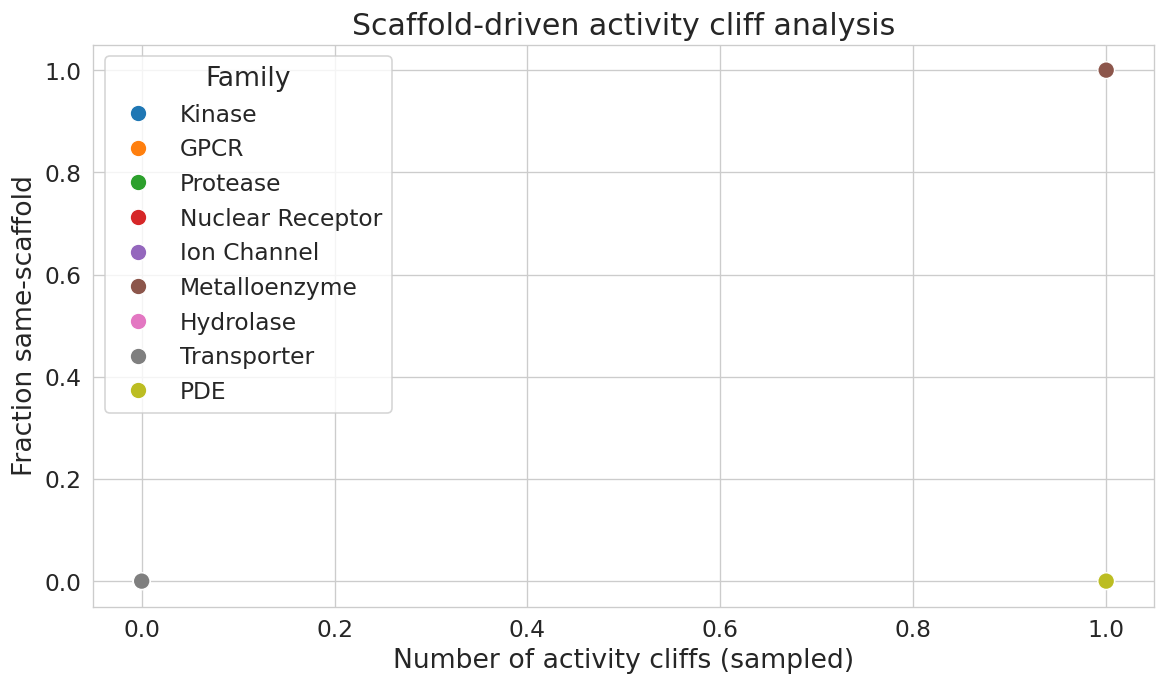

In [26]:
# Fig 7: Scaffold cliff scatter (Cliffs vs Same-scaffold fraction)
scaf_df_plot = scaf_df.copy()
scaf_df_plot['Label'] = scaf_df_plot['Protein'] + ' (' + scaf_df_plot['Family'] + ')'
plt.figure(figsize=(10,6))
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})
sns.scatterplot(data=scaf_df_plot, x='Cliffs_found', y='Same_scaffold_fraction', hue='Family', s=100)
plt.xlabel('Number of activity cliffs (sampled)'); plt.ylabel('Fraction same-scaffold'); plt.title('Scaffold-driven activity cliff analysis')
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'fig7_scaffold_cliffs.png'), dpi=1200); plt.show(); plt.close()


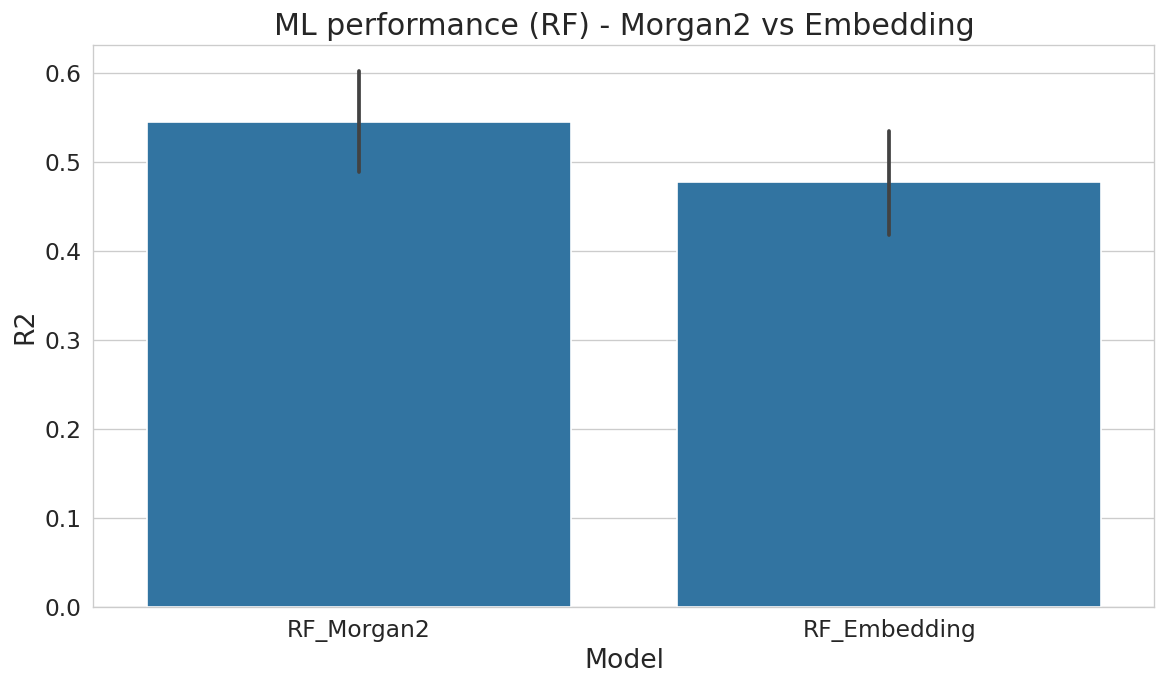

In [25]:
# Fig 8: ML performance comparison (R2 by model)
plt.figure(figsize=(10,6))
sns.barplot(data=ml_df, x='Model', y='R2')
plt.title('ML performance (RF) - Morgan2 vs Embedding');
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR,'fig8_ml_r2.png'), dpi=1200); plt.show(); plt.close()
